# ****Nifty50****

## *Import Libraries*

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [34]:
df = pd.read_csv("nifty50.csv")
df

,Date,Open,High,Low,Close,Shares Traded,Turnover(in cr)
0,01-Jan-18,10531.70,10537.85,10423.10,10435.55,134532090.0,7546.56
1,02-Jan-18,10477.55,10495.20,10404.65,10442.20,158092430.0,8665.47
2,03-Jan-18,10482.65,10503.60,10429.55,10443.20,172516859.0,9541.60
3,04-Jan-18,10469.40,10513.00,10441.45,10504.80,180257392.0,9561.95
4,05-Jan-18,10534.25,10566.10,10520.10,10558.85,186469717.0,10306.22
...,...,...,...,...,...,...,...
1575,14-May-24,22112.90,22270.05,22081.25,22217.85,230238941.0,23741.66
1576,15-May-24,22255.60,22297.55,22151.75,22200.55,231935478.0,23815.79
1577,16-May-24,22319.20,22432.25,22054.55,22403.85,368945092.0,38836.11
1578,17-May-24,22415.25,22502.15,22345.65,22466.10,242654570.0,27388.67


In [35]:
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])

# Update layout for better visualization
fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

# Show the figure
fig.show()

In [3]:
# Parse the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the Date column as the index
df.set_index('Date', inplace=True)

# Sort the data by date
df.sort_index(inplace=True)

# Selecting the feature and target columns
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [4]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## *Model Definition*

In [22]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Get the last output of the sequence
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [6]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## *Training*

In [7]:
num_epochs = 1000
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/1000, Loss: 0.027605030685663223
Epoch 2/1000, Loss: 0.041535645723342896
Epoch 3/1000, Loss: 0.024148566648364067
Epoch 4/1000, Loss: 0.0038001900538802147
Epoch 5/1000, Loss: 0.0032457930501550436
Epoch 6/1000, Loss: 0.002273722318932414
Epoch 7/1000, Loss: 0.000925598491448909
Epoch 8/1000, Loss: 0.0004921084037050605
Epoch 9/1000, Loss: 0.0011129488702863455
Epoch 10/1000, Loss: 0.0007327026687562466
Epoch 11/1000, Loss: 0.0007347834180109203
Epoch 12/1000, Loss: 0.001298806513659656
Epoch 13/1000, Loss: 0.0007548774592578411
Epoch 14/1000, Loss: 0.0004849850956816226
Epoch 15/1000, Loss: 0.0007747012423351407
Epoch 16/1000, Loss: 0.0009603489888831973
Epoch 17/1000, Loss: 0.0006160273915156722
Epoch 18/1000, Loss: 0.0006475124973803759
Epoch 19/1000, Loss: 0.001069726306013763
Epoch 20/1000, Loss: 0.0005747152026742697
Epoch 21/1000, Loss: 0.00043499944149516523
Epoch 22/1000, Loss: 0.0003711971512529999
Epoch 23/1000, Loss: 0.0004992429749108851
Epoch 24/1000, Loss: 0.001

## *Prediction and Evaluation*

In [8]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.numpy())

mse = np.mean((predictions - y_test_scaled) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 51336.98046875


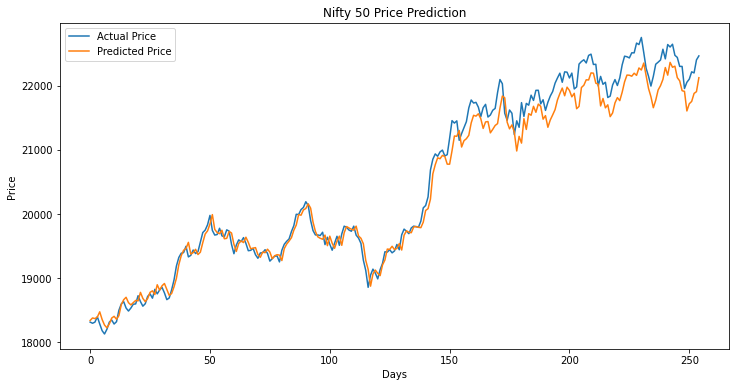

In [9]:
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(y_test_scaled, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Nifty 50 Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

## *Next 5 days prediction*

In [10]:
next_5_days_predictions = []
last_sequence = X_test[-1:, :, :]

for _ in range(5):
    with torch.no_grad():
        prediction = model(last_sequence)
        next_5_days_predictions.append(scaler.inverse_transform(prediction.numpy()))
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.unsqueeze(2)], dim=1)

print(next_5_days_predictions)

[array([[22126.17]], dtype=float32), array([[21896.982]], dtype=float32), array([[21713.1]], dtype=float32), array([[21509.363]], dtype=float32), array([[21262.842]], dtype=float32)]


In [11]:
# Plotting actual and predicted prices
colors = ['red', 'green', 'blue', 'orange', 'purple']

actual_trace = go.Scatter(x=df.index[-len(y_test):], y=y_test_scaled.flatten(), mode='lines', name='Actual Price', line=dict(color='blue'))
predicted_trace = go.Scatter(x=df.index[-len(predictions):], y=predictions.flatten(), mode='lines', name='Predicted Price', line=dict(color='orange'))

# Calculate the next 5 dates after the last date in the dataset
last_date = df.index[-1]
next_5_days_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

# Plotting prices for the next 5 days
next_5_days_trace = []
predict_price = predictions[-1][0]
for i, price in enumerate(next_5_days_predictions, start=1):
    next_day_trace = go.Scatter(x=[last_date, next_5_days_index[i-1]], y=[predict_price, price[0][0]], mode='lines', name=f'Next Day {i}', line=dict(color=colors[i-1]))
    next_5_days_trace.append(next_day_trace)
    last_date = next_5_days_index[i-1]
    predict_price = price[0][0]

# Combine all traces
traces = [actual_trace, predicted_trace] + next_5_days_trace

# Define layout
layout = go.Layout(title='Actual vs. Predicted Prices with Next 5 Days Predictions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price'),
                   legend=dict(orientation='h'),
                   showlegend=True)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show interactive plot
fig.show()


## *Save Model*

In [12]:
# Save the model
torch.save(model.state_dict(), "model_50.pth")

# ****Nifty100****

In [58]:
df1 = pd.read_csv('n1.csv')
df2 = pd.read_csv('n2.csv')
df3 = pd.read_csv('n3.csv')
df4 = pd.read_csv('n4.csv')
df5 = pd.read_csv('n5.csv')
df6 = pd.read_csv('n6.csv')
df7 = pd.read_csv('n7.csv')

In [60]:
all_dfs = [df7, df6, df5, df1, df4, df3, df2]
concatenated_df = pd.concat(all_dfs, ignore_index=True)

concatenated_df.to_csv("nifty100.csv")

## *Data Preparation and Processing*

In [61]:
df_100 = pd.read_csv("nifty100.csv")
df_100

,Date,Open,High,Low,Close,Shares Traded,Turnover(₹ Cr)
0,01-Jan-18,10990.45,10998.20,10884.85,10897.75,280255426.0,10064.06
1,02-Jan-18,10941.60,10959.00,10854.45,10899.30,360492746.0,12449.10
2,03-Jan-18,10942.45,10968.95,10894.40,10910.05,338608508.0,12932.12
3,04-Jan-18,10938.30,10990.50,10907.90,10982.15,389091952.0,13751.10
4,05-Jan-18,11015.05,11056.65,11004.80,11051.25,423432093.0,15598.21
...,...,...,...,...,...,...,...
1575,14-May-24,22979.40,23162.70,22942.25,23118.20,681745966.0,43231.60
1576,15-May-24,23177.80,23224.85,23078.05,23133.85,677790092.0,43913.27
1577,16-May-24,23258.80,23370.85,22997.50,23343.55,845774532.0,60532.96
1578,17-May-24,23368.35,23466.00,23307.25,23444.30,770240012.0,47179.61


In [62]:
df=df_100

In [63]:
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])

# Update layout for better visualization
fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

# Show the figure
fig.show()

In [64]:
# Parse the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the Date column as the index
df.set_index('Date', inplace=True)

# Sort the data by date
df.sort_index(inplace=True)

# Selecting the feature and target columns
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [65]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## *Call Model*

In [66]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## *Train Model*

In [67]:
num_epochs = 500
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/500, Loss: 0.10206297039985657
Epoch 2/500, Loss: 0.043296195566654205
Epoch 3/500, Loss: 0.0335698127746582
Epoch 4/500, Loss: 0.040348973125219345
Epoch 5/500, Loss: 0.02784736454486847
Epoch 6/500, Loss: 0.0033169169910252094
Epoch 7/500, Loss: 0.004485556855797768
Epoch 8/500, Loss: 0.0028672502376139164
Epoch 9/500, Loss: 0.0014268754748627543
Epoch 10/500, Loss: 0.001040847273543477
Epoch 11/500, Loss: 0.0009082575561478734
Epoch 12/500, Loss: 0.000875893805641681
Epoch 13/500, Loss: 0.0010685252491384745
Epoch 14/500, Loss: 0.0009514153935015202
Epoch 15/500, Loss: 0.0013298620469868183
Epoch 16/500, Loss: 0.0006344826542772353
Epoch 17/500, Loss: 0.001190404873341322
Epoch 18/500, Loss: 0.0007846307707950473
Epoch 19/500, Loss: 0.0008112293435260653
Epoch 20/500, Loss: 0.0003943343472201377
Epoch 21/500, Loss: 0.0002942074788734317
Epoch 22/500, Loss: 0.000931639748159796
Epoch 23/500, Loss: 0.0005132267251610756
Epoch 24/500, Loss: 0.000775572145357728
Epoch 25/500, Lo

## *Evaluate the Model*

In [68]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.numpy())

mse = np.mean((predictions - y_test_scaled) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 52829.19140625


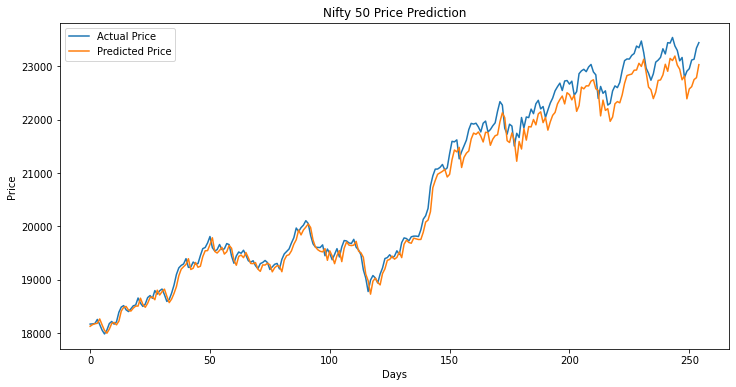

In [69]:
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(y_test_scaled, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Nifty 50 Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

## *Next 5 days prediction*

In [70]:
next_5_days_predictions = []
last_sequence = X_test[-1:, :, :]

for _ in range(5):
    with torch.no_grad():
        prediction = model(last_sequence)
        next_5_days_predictions.append(scaler.inverse_transform(prediction.numpy()))
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.unsqueeze(2)], dim=1)

print(next_5_days_predictions)

[array([[23031.998]], dtype=float32), array([[22688.328]], dtype=float32), array([[22378.695]], dtype=float32), array([[22111.492]], dtype=float32), array([[21809.074]], dtype=float32)]


In [71]:
# Plotting actual and predicted prices
colors = ['red', 'green', 'blue', 'orange', 'purple']

actual_trace = go.Scatter(x=df.index[-len(y_test):], y=y_test_scaled.flatten(), mode='lines', name='Actual Price', line=dict(color='blue'))
predicted_trace = go.Scatter(x=df.index[-len(predictions):], y=predictions.flatten(), mode='lines', name='Predicted Price', line=dict(color='orange'))

# Calculate the next 5 dates after the last date in the dataset
last_date = df.index[-1]
next_5_days_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

# Plotting prices for the next 5 days
next_5_days_trace = []
predict_price = predictions[-1][0]
for i, price in enumerate(next_5_days_predictions, start=1):
    next_day_trace = go.Scatter(x=[last_date, next_5_days_index[i-1]], y=[predict_price, price[0][0]], mode='lines', name=f'Next Day {i}', line=dict(color=colors[i-1]))
    next_5_days_trace.append(next_day_trace)
    last_date = next_5_days_index[i-1]
    predict_price = price[0][0]

# Combine all traces
traces = [actual_trace, predicted_trace] + next_5_days_trace

# Define layout
layout = go.Layout(title='Actual vs. Predicted Prices with Next 5 Days Predictions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price'),
                   legend=dict(orientation='h'),
                   showlegend=True)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show interactive plot
fig.show()


## *Save Model*

In [72]:
# Save the model
torch.save(model.state_dict(), "model_100.pth")

# ****Nifty MidCap50****

## *Data Preparation and Processing*

In [78]:
df_mid50 = pd.read_csv("niftymidcap50.csv")
df_mid50

,Date,Open,High,Low,Close,Shares Traded,Turnover(₹ Cr)
0,01-Jan-18,5553.40,5585.30,5517.80,5532.50,7.524685e+08,4813.21
1,02-Jan-18,5556.75,5565.55,5439.15,5478.35,6.270689e+08,4493.47
2,03-Jan-18,5495.50,5530.30,5492.65,5513.05,4.780665e+08,4376.69
3,04-Jan-18,5536.35,5566.55,5509.35,5560.95,6.937297e+08,5540.18
4,05-Jan-18,5585.40,5640.75,5575.40,5635.70,6.883890e+08,5853.99
...,...,...,...,...,...,...,...
1575,14-May-24,14091.10,14189.10,14004.00,14163.15,1.174648e+09,9821.89
1576,15-May-24,14213.10,14281.25,14156.00,14262.55,7.862335e+08,9524.33
1577,16-May-24,14314.55,14411.50,14263.25,14396.90,8.757429e+08,12013.37
1578,17-May-24,14440.30,14525.15,14404.25,14515.20,1.039974e+09,13009.72


In [79]:
df=df_mid50

In [80]:
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])

# Update layout for better visualization
fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

# Show the figure
fig.show()

In [81]:
# Parse the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the Date column as the index
df.set_index('Date', inplace=True)

# Sort the data by date
df.sort_index(inplace=True)

# Selecting the feature and target columns
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [82]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## *Call Model*

In [83]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## *Train Model*

In [84]:
num_epochs = 500
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/500, Loss: 0.02650887332856655
Epoch 2/500, Loss: 0.018255803734064102
Epoch 3/500, Loss: 0.004159720614552498
Epoch 4/500, Loss: 0.0018352778861299157
Epoch 5/500, Loss: 0.0011900480603799224
Epoch 6/500, Loss: 0.000512892147526145
Epoch 7/500, Loss: 0.0008946981397457421
Epoch 8/500, Loss: 0.0005699783796444535
Epoch 9/500, Loss: 0.0003393683582544327
Epoch 10/500, Loss: 0.00035589406616054475
Epoch 11/500, Loss: 0.00044310270459391177
Epoch 12/500, Loss: 0.0004001689376309514
Epoch 13/500, Loss: 0.0003715908678714186
Epoch 14/500, Loss: 0.000321166415233165
Epoch 15/500, Loss: 0.00038190570194274187
Epoch 16/500, Loss: 0.00030196720035746694
Epoch 17/500, Loss: 0.00018945473129861057
Epoch 18/500, Loss: 0.0002983058802783489
Epoch 19/500, Loss: 0.000675106537528336
Epoch 20/500, Loss: 0.00040493003325536847
Epoch 21/500, Loss: 0.00022384515614248812
Epoch 22/500, Loss: 0.0003067167417611927
Epoch 23/500, Loss: 0.0003069004160352051
Epoch 24/500, Loss: 0.000353000097675249
Ep

## *Evaluate the Model*

In [85]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.numpy())

mse = np.mean((predictions - y_test_scaled) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 410952.21875


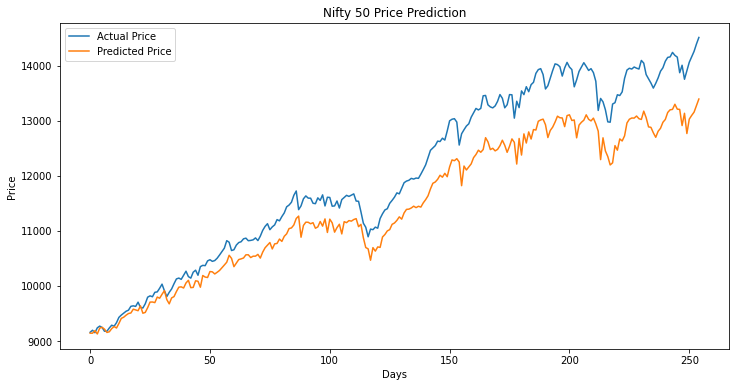

In [86]:
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(y_test_scaled, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Nifty 50 Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

## *Next 5 days prediction*

In [87]:
next_5_days_predictions = []
last_sequence = X_test[-1:, :, :]

for _ in range(5):
    with torch.no_grad():
        prediction = model(last_sequence)
        next_5_days_predictions.append(scaler.inverse_transform(prediction.numpy()))
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.unsqueeze(2)], dim=1)

print(next_5_days_predictions)

[array([[13396.656]], dtype=float32), array([[12315.185]], dtype=float32), array([[11492.35]], dtype=float32), array([[10774.088]], dtype=float32), array([[10035.033]], dtype=float32)]


In [88]:
# Plotting actual and predicted prices
colors = ['red', 'green', 'blue', 'orange', 'purple']

actual_trace = go.Scatter(x=df.index[-len(y_test):], y=y_test_scaled.flatten(), mode='lines', name='Actual Price', line=dict(color='blue'))
predicted_trace = go.Scatter(x=df.index[-len(predictions):], y=predictions.flatten(), mode='lines', name='Predicted Price', line=dict(color='orange'))

# Calculate the next 5 dates after the last date in the dataset
last_date = df.index[-1]
next_5_days_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

# Plotting prices for the next 5 days
next_5_days_trace = []
predict_price = predictions[-1][0]
for i, price in enumerate(next_5_days_predictions, start=1):
    next_day_trace = go.Scatter(x=[last_date, next_5_days_index[i-1]], y=[predict_price, price[0][0]], mode='lines', name=f'Next Day {i}', line=dict(color=colors[i-1]))
    next_5_days_trace.append(next_day_trace)
    last_date = next_5_days_index[i-1]
    predict_price = price[0][0]

# Combine all traces
traces = [actual_trace, predicted_trace] + next_5_days_trace

# Define layout
layout = go.Layout(title='Actual vs. Predicted Prices with Next 5 Days Predictions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price'),
                   legend=dict(orientation='h'),
                   showlegend=True)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show interactive plot
fig.show()


## *Save Model*

In [89]:
# Save the model
torch.save(model.state_dict(), "model_MidCap50.pth")